# Probabilistic Time Series Forecasting with 🤗 Transformers

## Introduction

Time series forecasting is an essential scientific and business problem and as such has also seen a lot of innovation recently with the use of [deep learning based](https://dl.acm.org/doi/abs/10.1145/3533382) models in addition to the [classical methods](https://otexts.com/fpp3/). An important difference between classical methods like ARIMA and novel deep learning methods is the following.

##  Probabilistic Forecasting

Typically, classical methods are fitted on each time series in a dataset individually. These are often referred to as  "single" or "local" methods. However, when dealing with a large amount of time series for some applications, it is beneficial to train a "global" model on all available time series, which enables the model to learn latent representations from many different sources.

Some classical methods are point-valued (meaning, they just output a single value per time step) and models are trained by minimizing an L2 or L1 type of loss with respect to the ground truth data. However, since forecasts are often used in some real-world decision making pipeline, even with humans in the loop, it is much more beneficial to provide the uncertainties of predictions. This is also called "probabilistic forecasting", as opposed to "point forecasting". This entails modeling a probabilistic distribution, from which one can sample.

So in short, rather than training local point forecasting models, we hope to train **global probabilistic** models. Deep learning is a great fit for this, as neural networks can learn representations from several related time series as well as model the uncertainty of the data.

It is common in the probabilistic setting to learn the future parameters of some chosen parametric distribution, like Gaussian or Student-T; or learn the conditional quantile function; or use the framework of Conformal Prediction adapted to the time series setting. The choice of method does not affect the modeling aspect and thus can be typically thought of as yet another hyperparameter. One can always turn a probabilistic model into a point-forecasting model, by taking empirical means or medians.

## The Time Series Transformer

In terms of modeling time series data which are sequential in nature, as one can imagine, researchers have come up with models which use Recurrent Neural Networks (RNN) like LSTM or GRU, or Convolutional Networks (CNN), and more recently Transformer based methods which fit naturally to the time series forecasting setting.

In this blog post, we're going to leverage the vanilla Transformer [(Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762) for the **univariate** probabilistic forecasting task (i.e. predicting each time series' 1-d distribution individually). The Encoder-Decoder Transformer is a natural choice for forecasting as it encapsulates several inductive biases nicely.

To begin with, the use of an Encoder-Decoder architecture is helpful at inference time where typically for some logged data we wish to forecast some prediction steps into the future. This can be thought of as analogous to the text generation task where given some context, we sample the next token and pass it back into the decoder (also called "autoregressive generation"). Similarly here we can also, given some distribution type, sample from it to provide forecasts up until our desired prediction horizon. This is known as Greedy Sampling/Search and there is a great blog post about it [here](https://huggingface.co/blog/how-to-generate) for the NLP setting.

Secondly, a Transformer helps us to train on time series data which might contain thousands of time points. It might not be feasible to input *all* the history of a time series at once to the model, due to the time- and memory constraints of the attention mechanism. Thus, one can consider some appropriate context window and sample this window and the subsequent prediction length sized window from the training data when constructing batches for stochastic gradient descent (SGD). The context sized window can be passed to the encoder and the prediction window to a *causal-masked* decoder. This means that the decoder can only look at previous time steps when learning the next value. This is equivalent to how one would train a vanilla Transformer for machine translation, referred to as "teacher forcing".

Another benefit of Transformers over the other architectures is that we can incorporate missing values (which are common in the time series setting) as an additional mask to the encoder or decoder and still train without resorting to in-filling or imputation. This is equivalent to the `attention_mask` of models like BERT and GPT-2 in the Transformers library, to not include padding tokens in the computation of the attention matrix.

A drawback of the Transformer architecture is the limit to the sizes of the context and prediction windows because of the quadratic compute and memory requirements of the vanilla Transformer, see [Tay et al., 2020](https://arxiv.org/abs/2009.06732). Additionally, since the Transformer is a powerful architecture, it might overfit or learn spurious correlations much more easily compared to other [methods](https://openreview.net/pdf?id=D7YBmfX_VQy).

The 🤗 Transformers library comes with a vanilla probabilistic time series Transformer model, simply called the [Time Series Transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer). In the sections below, we'll show how to train such a model on a custom dataset.

## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate,  🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
!pip install -q transformers

     |████████████████████████████████| 5.8 MB 13.9 MB/s 
     |████████████████████████████████| 182 kB 44.5 MB/s 
     |████████████████████████████████| 7.6 MB 49.1 MB/s 


In [2]:
!pip install -q datasets

     |████████████████████████████████| 451 kB 41.1 MB/s 
     |████████████████████████████████| 132 kB 74.4 MB/s 
     |████████████████████████████████| 212 kB 63.3 MB/s 
     |████████████████████████████████| 127 kB 73.6 MB/s 


In [3]:
!pip install -q evaluate

     |████████████████████████████████| 72 kB 1.5 MB/s 


In [4]:
!pip install -q accelerate

     |████████████████████████████████| 191 kB 21.7 MB/s 


In [5]:
!pip install -q gluonts ujson

     |████████████████████████████████| 1.0 MB 29.8 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 


## Load Dataset

In this blog post, we'll use the `tourism_monthly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains monthly tourism volumes for 366 regions in Australia.

This dataset is part of the [Monash Time Series Forecasting](https://forecastingdata.org/) repository, a collection of  time series datasets from a number of domains. It can be viewed as the GLUE benchmark of time series forecasting.

In [6]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "tourism_monthly")

Generating train split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/366 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/366 [00:00<?, ? examples/s]

Dataset monash_tsf downloaded and prepared to /root/.cache/huggingface/datasets/monash_tsf/tourism_monthly/1.0.0/82998723d55d6edbc664cfaebe371004d849846ee5f61b57f1f974000d44c050. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

As can be seen, the dataset contains 3 splits: train, validation and test.

In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 366
    })
})

Each example contains a few keys, of which `start` and `target` are the most important ones. Let us have a look at the first time series in the dataset:

In [8]:
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The `start` simply indicates the start of the time series (as a datetime), and the `target` contains the actual values of the time series.

The `start` will be useful to add time related features to the time series values, as extra input to the model (such as "month of year"). Since we know the frequency of the data is `monthly`, we know for instance that the second value has the timestamp `1979-02-01`, etc.

In [9]:
print(train_example['start'])
print(train_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

The validation set contains the same data as the training set, just for a `prediction_length` longer amount of time. This allows us to validate the model's predictions against the ground truth.

The test set is again one `prediction_length` longer data compared to the validation set (or some multiple of  `prediction_length` longer data compared to the training set for testing on multiple rolling windows).

In [10]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The initial values are exactly the same as the corresponding training example:

In [11]:
print(validation_example['start'])
print(validation_example['target'])

1979-01-01 00:00:00
[1149.8699951171875, 1053.8001708984375, 1388.8797607421875, 1783.3702392578125, 1921.025146484375, 2704.94482421875, 4184.41357421875, 4148.35400390625, 2620.72509765625, 1650.300048828125, 1115.9200439453125, 1370.6251220703125, 1096.31494140625, 978.4600219726562, 1294.68505859375, 1480.465087890625, 1748.865234375, 2216.920166015625, 4690.5185546875, 4682.8642578125, 2459.579833984375, 1484.4901123046875, 1028.985107421875, 1109.3648681640625, 960.8751220703125, 896.35009765625, 1118.6551513671875, 1619.9949951171875, 1847.994873046875, 2367.044921875, 4991.16015625, 4772.9443359375, 2894.678466796875, 1860.4801025390625, 1185.150146484375, 1313.659912109375, 1160.9150390625, 1061.5048828125, 1301.77001953125, 1794.3797607421875, 2106.455078125, 2789.034912109375, 4917.8466796875, 4994.4833984375, 3016.754150390625, 1941.505126953125, 1234.135009765625, 1378.72021484375, 1182.9749755859375, 1081.6600341796875, 1424.110107421875, 1774.5350341796875, 2115.42016601

However, this example has `prediction_length=24` additional values compared to the training example. Let us verify it.

In [12]:
freq = "1M"
prediction_length = 24

assert len(train_example['target']) + prediction_length == len(validation_example['target'])

Let's visualize this:

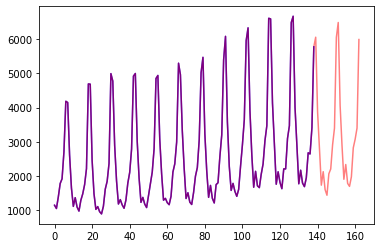

In [13]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example['target'], color="blue") 
axes.plot(validation_example['target'], color="red", alpha=0.5)

plt.show()

Let's split up the data:

In [14]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

## Update `start` to `pd.Period` and transform `target`

The first thing we'll do is convert the `start` feature of each time series to a pandas `Period` index using the data's `freq`:

In [15]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq, log1p=False):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    if log1p:
        batch["target"] = [np.log1p(value) for value in batch["target"]]
    return batch

We now use `datasets`' [`set_transform`](https://huggingface.co/docs/datasets/v2.7.0/en/package_reference/main_classes#datasets.Dataset.set_transform) functionality to do this on-the-fly in place:

In [16]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq, log1p=False))
test_dataset.set_transform(partial(transform_start_field, freq=freq, log1p=False))

## Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `24` months): this is the horizon that the decoder of the Transformer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify how much we "look back", to be added as additional features. e.g. for a `Daily` frequency we might consider a look back of `[1, 2, 7, 30, ...]` or in other words look back 1, 2, ... days while for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `2` as we'll add `MonthOfYear` and `Age` features;
- the number of static categorical features: in our case, this will be just `1` as we'll add a single "time series ID" feature;
- the cardinality: the number of values of each static categorical feature, as a list which for our case will be `[366]` as we have 366 different time series
- the embedding dimension: the embedding dimension for each static categorical feature, as a list, for example `[3]` meaning the model will learn an embedding vector of size `3` for each of the `366` time series (regions).


Let's use the default lags provided by GluonTS for the given frequency ("monthly"):

In [17]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]


This means that we'll look back up to 37 months for each time step, as additional features.

Let's also check the default time features which GluonTS provides us:

In [18]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function month_of_year at 0x7f72db145dc0>]


In this case, there's only a single feature, namely "month of year". This means that for each time step, we'll add the month as a scalar value (e.g. `1` in case the timestamp is "january", `2` in case the timestamp is "february", etc.).

We now have everything to define the model:

In [19]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    context_length=prediction_length*6, # context length
    lags_sequence=lags_sequence,
    num_time_features=len(time_features) + 1, # we'll add 2 time features ("month of year" and "age", see further)
    num_static_categorical_features=1, # we have a single static categorical feature, namely time series ID
    cardinality=[len(train_dataset)], # it has 366 possible values
    embedding_dimension=[2], # the model will learn an embedding of size 2 for each of the 366 possible values
    encoder_layers=4, 
    decoder_layers=4,
)

model = TimeSeriesTransformerForPrediction(config)

Note that, similar to other models in the 🤗 Transformers library, [`TimeSeriesTransformerModel`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerModel) corresponds to the encoder-decoder Transformer without any head on top, and [`TimeSeriesTransformerForPrediction`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction) corresponds to `TimeSeriesTransformerModel` with a **distribution head** on top. By default, the model uses a Student-t distribution (but this is configurable):

In [20]:
model.config.distribution_output

'student_t'

This is an important difference with Transformers for NLP, where the head typically consists of a fixed categorical distribution implemented as an `nn.Linear` layer.

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [21]:
from gluonts.time_feature import time_features_from_frequency_str, TimeFeature, get_lags_for_frequency
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [22]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: use static features if available, if not add dummy values
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
            if not config.num_static_categorical_features > 0
            else []
        )
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_REAL, value=[0.0])]
            if not config.num_static_real_features > 0
            else []
        )
        # step 3: convert the data to NumPy (potentially not needed)
        + [
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_CAT,
                expected_ndim=1,
                dtype=int,
            ),
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_REAL,
                expected_ndim=1,
            ),
            AsNumpyArray(
                field=FieldName.TARGET,
                # in the following line, we add 1 for the time dimension
                expected_ndim=1 if config.input_size==1 else 2,
            ),
            # step 4: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 5: add temporal features based on freq of the dataset
            # month of year in this case
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 6: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 7: vertically stack all the temporal features
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + ([FieldName.FEAT_DYNAMIC_REAL] if config.num_dynamic_real_features > 0 else []),
            ),
            # step 8: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )


## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the Transformer due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [23]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(config: PretrainedConfig, mode: str, train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation":  validation_sampler or ValidationSplitSampler(
            min_future=config.prediction_length
        ),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=[
            "time_features",
            "observed_mask",
        ],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output pairs) - or in other words (`past_values`, `future_values`).

In [24]:
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset
from torch.utils.data import DataLoader

from typing import Iterable

def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    
    # we initialize a Training instance
    instance_splitter = create_instance_splitter(
        config, "train"
    ) + SelectFields(TRAINING_INPUT_NAMES)


    # the instance splitter will sample a window of 
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data), 
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # from the training instances iterator we now return a Dataloader which will 
    # continue to sample random windows for as long as it is called
    # to return batch_size of the appropriate tensors ready for training!
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )

In [25]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "static_categorical_features",
        "static_real_features",
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
        ]
    
    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)
    
    # we create a Test Instance splitter which will sample the very last 
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(
        config, "test"
    ) + SelectFields(PREDICTION_INPUT_NAMES)
    
    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    # This returns a Dataloader which will go over the dataset once.
    return DataLoader(IterableDataset(testing_instances), batch_size=batch_size, **kwargs)

In [26]:
train_dataloader = create_train_dataloader(
    config=config, 
    freq=freq, 
    data=train_dataset, 
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config, 
    freq=freq, 
    data=test_dataset, 
    batch_size=64,
)

Let's check the first batch:

In [27]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape, v.type())

static_categorical_features torch.Size([256, 1]) torch.LongTensor
static_real_features torch.Size([256, 1]) torch.FloatTensor
past_time_features torch.Size([256, 181, 2]) torch.FloatTensor
past_values torch.Size([256, 181]) torch.FloatTensor
past_observed_mask torch.Size([256, 181]) torch.FloatTensor
future_time_features torch.Size([256, 24, 2]) torch.FloatTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features`, `static_categorical_features` and `static_real_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction.forward.past_values) for a detailed explanation for each of them.

## Forward pass

Let's perform a single forward pass with the batch we just created:

In [28]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"],
    static_real_features=batch["static_real_features"],
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True
)

In [29]:
print("Loss:", outputs.loss.item())

Loss: 9.141253471374512


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [30]:
from accelerate import Accelerator
from torch.optim import Adam

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
 
model, optimizer, train_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, 
)

model.train()
for epoch in range(40):
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device),
            static_real_features=batch["static_real_features"].to(device),
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        print(loss.item())

9.262197494506836
8.572096824645996
8.929058074951172
9.423008918762207
8.715765953063965
8.408944129943848
9.53319263458252
9.050007820129395
8.415474891662598
8.782164573669434
8.927314758300781
8.546066284179688
8.274490356445312
9.317761421203613
8.750452041625977
8.369924545288086
8.797771453857422
8.958977699279785
8.366541862487793
8.104302406311035
9.382204055786133
8.291304588317871
7.8878655433654785
9.069355964660645
8.576685905456543
8.16900634765625
8.441224098205566
8.624401092529297
8.38591480255127
7.8353271484375
8.90223217010498
8.29039478302002
8.131529808044434
7.870341777801514
8.892349243164062
8.55107593536377
7.754493713378906
8.254044532775879
8.516361236572266
8.28710651397705
7.685766696929932
8.658307075500488
8.257542610168457
7.970961093902588
7.7883124351501465
8.514163970947266
8.11931324005127
7.667291641235352
8.66322135925293
7.959115505218506
7.528522968292236
8.317631721496582
8.254609107971191
7.935842037200928
7.831621170043945
8.501951217651367
8

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [40]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device),
        static_real_features=batch["static_real_features"].to(device),
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`). 

In this case, we get `100` possible values for the next `24` months (for each example in the batch which is of size `64`):

In [41]:
forecasts[0].shape

(64, 100, 24)

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [42]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

(366, 100, 24)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series in the dataset:

In [43]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])

In [44]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.361636922541396


In [45]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.17457818831512306


We can also plot the individual metrics of each time series in the dataset and observe that a handful of time series contribute a lot to the final test metric:

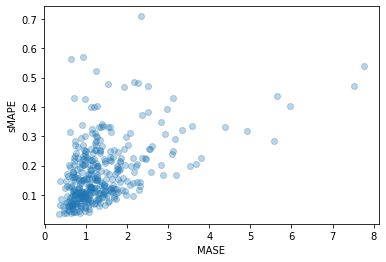

In [46]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

To plot the prediction for any time series with respect the ground truth test data we define the following helper:

In [47]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

For example:

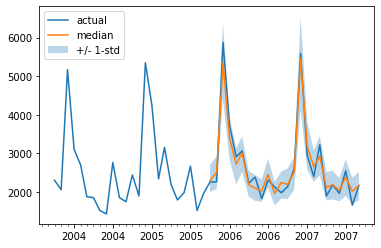

In [48]:
plot(334)

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can add to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet| 	**Transformer** (Our) |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|
|Tourism Monthly | 	3.306 |	1.649 |	1.751 |	1.526|	1.589|	1.678	|1.699|	1.582	| 1.409	| 1.574|	1.482	|  **1.361**|

Note that, with our model, we are beating all other models reported (see also table 2 in the corresponding [paper](https://openreview.net/pdf?id=wEc1mgAjU-)), and we didn't do any hyperparameter tuning. We just trained the Transformer for 40 epochs. 

Of course, we need to be careful with just claiming state-of-the-art results on time series with neural networks, as it seems ["XGBoost is typically all you need"](https://www.sciencedirect.com/science/article/pii/S0169207021001679).  We are just very curious to see how far neural networks can bring us, and whether Transformers are going to be useful in this domain. This particular dataset seems to indicate that it's definitely worth exploring.

## Next Steps

We would encourage the readers to try out the [notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb) with other time series datasets from the [Hub](https://huggingface.co/datasets/monash_tsf) and replace the appropriate frequency and prediction length parameters. For your datasets, one would need to convert them to the convention used by GluonTS, which is explained nicely in their documentation [here](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?). We have also prepared an example notebook showing you how to convert your dataset into the 🤗 datasets format [here](https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb).

As time series researchers will know, there has been a lot of interest in applying Transformer based models to the time series problem. The vanilla Transformer is just one of many attention-based models and so there is a need to add more models to the library.

At the moment there is nothing stopping us from modeling multivariate time series, however for that one would need to instantiate the model with a multivariate distribution head. Currently, diagonal independent distributions are supported, and other multivariate distributions will be added. Stay tuned for a future blog post which will include a tutorial.

Another thing on the roadmap is time series classification. This entails adding a time series model with a classification head to the library, for the anomaly detection task for example. 

The current model assumes the presence of a date-time together with the time series values, which might not be the case for every time series in the wild. See for instance neuroscience datasets like the one from [WOODS](https://woods-benchmarks.github.io/). Thus, one would need to generalize the current model to make some inputs optional in the whole pipeline.

Finally, the NLP/Vision domain has benefitted tremendously from [large pre-trained models](https://arxiv.org/abs/1810.04805), while this is not the case as far as we are aware for the time series domain. Transformer based models seem like the obvious choice in pursuing this avenue of research and we cannot wait to see what researchers and practitioners come up with!
